<a href="https://colab.research.google.com/github/madanmohan-venkatesan/notebooks/blob/main/2011_03567.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns

# 2. A sequential multinomial test


In [2]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

In [3]:
theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

In [4]:
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

In [5]:
s_n_null=np.sum(vectors_null,axis=0)
s_n_alt=np.sum(vectors_alt,axis=0)

In [6]:
def beta(v):

  numerator=np.prod(gamma(v))
  denominator=gamma(np.sum(v))
  result=numerator/denominator
  if np.isnan(result).any():
    return np.array([np.inf])
  else:
    return result


In [7]:
def bf_10(dirichlet_alpha,theta,counts):
  term1_numerator=beta(dirichlet_alpha+counts)
  term1_denominator=beta(dirichlet_alpha)
  term1=term1_numerator/term1_denominator

  term2=1/(theta**counts)
  result=term1*term2

  if np.isnan(result).any() or np.isinf(result).any():
    return np.array([np.inf]*len(result))
  else:
    return result


In [8]:
bf_10(alpha_dirichlet,theta_null,s_n_alt)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-6-ffb25cde8259>:5: RuntimeWarning: invalid value encountered in scalar divide
  result=numerator/denominator


array([inf, inf])

For above bf_10, if theta_0 not equal theta then values will go to infinity (reject null hypothesis)
otherwise value is zero(accept null hypothesis)

Hyper paramters to play around with are K and vector size



In [9]:
theta_null_arr=[]
theta_alt_arr=[]
dirichlet_alpha_arr=[]
vetors_null_arr=[]
vectors_alt_arr=[]
for i in range(10):
  if i==0:
    K=10
  else:
    K=K#+(0.5*K)
  #generate null vectors
  theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
  rng = np.random.default_rng()
  vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
  #generate alt vectors

  alpha_dirichlet=K*theta_null
  rng = np.random.default_rng()
  theta_alt=rng.dirichlet(alpha_dirichlet)
  vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

  theta_null_arr.append(theta_null)
  theta_alt_arr.append(theta_alt)
  dirichlet_alpha_arr.append(alpha_dirichlet)
  vetors_null_arr.append(vectors_null)
  vectors_alt_arr.append(vectors_alt)

In [10]:
on_theta_hist_arr=[]
for i in range(len(theta_null_arr)):
  on_theta_prev = None
  if i==0:
    on_theta_prev = np.array([1,1])
    on_theta_hist_arr.append(on_theta_prev)

  else:
    s_n_null=np.sum(vetors_null_arr[i],axis=0)
    s_n_alt=np.sum(vectors_alt_arr[i],axis=0)
    term1_numerator=beta(dirichlet_alpha_arr[i]+s_n_alt)
    term1_denominator=beta(dirichlet_alpha_arr[i])
    term1=term1_numerator/term1_denominator

    term2=1/(theta_null_arr[i]**s_n_alt)

    on_theta_hist_arr.append(on_theta_hist_arr[i-1]*term1*term2)

# Optimization problem for theta

In [11]:
def objective(theta, i,maximize=True):
    """
    Objective function to maximize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to maximize.

    Returns:
    - float: Negative of theta[i] to convert minimization to maximization.
    """
    if maximize:
        return -theta[i]
    else:
      return theta[i]

def constraint_sum(theta):
    """
    Constraint ensuring that the sum of theta is 1.

    Parameters:
    - theta (array): Probability vector (simplex).

    Returns:
    - float: Sum of theta - 1 (should be 0).
    """
    return np.sum(theta) - 1

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Left-hand side of the constraint.
    """

    epsilon = 1e-10
    return np.sum(Sn * np.log(np.clip(theta, epsilon, None))) - c

# Real simulation

In [12]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
K=15
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)


on_theta_hist_arr=[]
theta_alt_1max_arr=[]
theta_alt_1min_arr=[]

theta_alt_0max_arr=[]
theta_alt_0min_arr=[]

seq_p_val_arr=[]
counter=0
for i in range(0,VECTOR_SIZE,int(VECTOR_SIZE/100)):

  on_theta_prev = None
  vectors_null_i=[]
  vectors_alt_i=[]
  if counter==0:
    on_theta_prev = np.array([1]*CLASSES)
    vectors_null_i=vectors_null[counter]
    vectors_alt_i=vectors_alt[counter]
    on_theta_hist_arr.append(on_theta_prev)
    seq_p_val_arr.append(np.array([1]*CLASSES))
  else:
    vectors_null_i=vectors_null[:i]
    vectors_alt_i=vectors_alt[:i]

  s_n_null=np.sum(vectors_null_i,axis=0)
  s_n_alt=np.sum(vectors_alt_i,axis=0)

  term1_numerator=beta(alpha_dirichlet+s_n_alt)
  term1_denominator=beta(alpha_dirichlet)
  term1=term1_numerator/term1_denominator

  term2=1/(theta_null**s_n_alt)
  on_theta_curr=on_theta_hist_arr[-1]*term1*term2
  print(counter)


  if ((on_theta_curr >= 1/0.05).any()) or (np.isnan(on_theta_curr).any()):
    print("Reject null hypothesis")
    break
  else:
    print("Accept null hypothesis")

  if ((on_theta_curr < 1/0.05).any()) or (np.isnan(on_theta_curr).any()):
    print("proceeding with optimization")
  else:
    print("Reject null hypothesis")
    break

  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
  u = 0.05  # Example confidence level
  c += np.log(u)

  # Initial guess for theta (uniform distribution)
  initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

  # Constraints
  constraints = [
      {'type': 'eq', 'fun': constraint_sum},
      {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
  ]

  # Bounds to ensure theta remains within [0, 1]
  bounds = [(0, 1) for _ in range(len(theta_alt))]

  # Solve the optimization problem
  result0 = minimize(objective, initial_theta, args=(0,True), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,True), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0max_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)
      break

  if result1.success:
      theta_alt_1max_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)
      break




  # Solve the optimization problem

  result0 = minimize(objective, initial_theta, args=(0,False), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,False), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0min_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)
      break

  if result1.success:
      theta_alt_1min_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)
      break
  if counter>0:
    on_theta_hist_arr.append(on_theta_curr)
    # p_val=np.clip(1/on_theta_curr,1/on_theta_curr,seq_p_val_arr[counter-1])
    p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr)
    seq_p_val_arr.append(p_val)

  counter+=1

0
Accept null hypothesis
proceeding with optimization
1
Accept null hypothesis
proceeding with optimization
2
Accept null hypothesis
proceeding with optimization
3
Accept null hypothesis
proceeding with optimization
4
Accept null hypothesis
proceeding with optimization
5
Accept null hypothesis
proceeding with optimization
6
Accept null hypothesis
proceeding with optimization
7
Accept null hypothesis
proceeding with optimization
8
Accept null hypothesis
proceeding with optimization
9
Accept null hypothesis
proceeding with optimization
10
Accept null hypothesis
proceeding with optimization
11
Accept null hypothesis
proceeding with optimization
12
Accept null hypothesis
proceeding with optimization
13
Accept null hypothesis
proceeding with optimization
14
Accept null hypothesis
proceeding with optimization
15
Accept null hypothesis
proceeding with optimization
16
Accept null hypothesis
proceeding with optimization
17
Accept null hypothesis
proceeding with optimization
18
Accept null hypot

<ipython-input-12-18f765b229a9>:119: RuntimeWarning: overflow encountered in divide
  p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr)


61
Accept null hypothesis
proceeding with optimization


<ipython-input-12-18f765b229a9>:119: RuntimeWarning: divide by zero encountered in divide
  p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr)


62
Accept null hypothesis
proceeding with optimization
63
Accept null hypothesis
proceeding with optimization
64
Accept null hypothesis
proceeding with optimization
65
Accept null hypothesis
proceeding with optimization
66
Accept null hypothesis
proceeding with optimization
67
Accept null hypothesis
proceeding with optimization
68
Accept null hypothesis
proceeding with optimization
69
Accept null hypothesis
proceeding with optimization
70
Accept null hypothesis
proceeding with optimization
71
Accept null hypothesis
proceeding with optimization
72
Accept null hypothesis
proceeding with optimization
73
Accept null hypothesis
proceeding with optimization
74
Accept null hypothesis
proceeding with optimization
75
Accept null hypothesis
proceeding with optimization
76
Accept null hypothesis
proceeding with optimization
77
Accept null hypothesis
proceeding with optimization
78
Accept null hypothesis
proceeding with optimization
79
Accept null hypothesis
proceeding with optimization
80
Accept 

In [13]:
theta_alt

array([0.42856979, 0.57143021])

In [14]:
print(len(on_theta_hist_arr))
print(len(theta_alt_1max_arr))
print(len(theta_alt_1min_arr))
print(len(theta_alt_0max_arr))
print(len(theta_alt_0min_arr))
print(len(seq_p_val_arr))



100
100
100
100
100
100


In [15]:
# seq_p_val_arr

In [16]:
print(len(np.array(seq_p_val_arr)[:-1,0]))

99


In [33]:
import numpy as np
from scipy.optimize import minimize
# from scipy.special import beta

# Updated objective function
def objective(theta, i, maximize=True):
    """
    Objective function to maximize or minimize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to optimize.
    - maximize (bool): True to maximize, False to minimize.

    Returns:
    - float: Optimized theta[i] (negative for maximization).
    """
    if maximize:
        return -theta[i]  # Maximize by minimizing the negative
    else:
        return theta[i]  # Minimize directly

# Constraint for the sum of theta to be 1 (simplex condition)
def constraint_sum(theta):
    return np.sum(theta) - 1

# Log-likelihood constraint with numerical stability
epsilon = 1e-10  # Small constant for numerical stability

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint ensuring numerical stability.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Result of the log-likelihood constraint.
    """
    return np.sum(Sn * np.log(np.clip(theta, epsilon, None))) - c

# Constants
CLASSES = 2
VECTOR_SIZE = 100
theta_null = np.array([1 / CLASSES] * CLASSES)  # Initial null hypothesis (simplex)
rng = np.random.default_rng()
vectors_null = rng.multinomial(1, theta_null, size=VECTOR_SIZE)
K = 0.1
alpha_dirichlet = K * theta_null
theta_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, theta_alt, size=VECTOR_SIZE)

# Storage for results
theta_alt_1max_arr = []
theta_alt_1min_arr = []
theta_alt_0max_arr = []
theta_alt_0min_arr = []

seq_p_val_arr = []
counter = 0

# Iterative procedure for calculating bounds
for i in range(0, VECTOR_SIZE, VECTOR_SIZE // 100):
    vectors_null_i = []
    vectors_alt_i = []

    if counter == 0:
        on_theta_prev = np.array([1] * CLASSES)
        vectors_null_i = vectors_null[counter]
        vectors_alt_i = vectors_alt[counter]
        seq_p_val_arr.append(np.array([1] * CLASSES))
    else:
        vectors_null_i = vectors_null[:i]
        vectors_alt_i = vectors_alt[:i]

    s_n_null = np.sum(vectors_null_i, axis=0)
    s_n_alt = np.sum(vectors_alt_i, axis=0)

    # Calculate term1 for the Bayesian update
    term1_numerator = beta(alpha_dirichlet + s_n_alt)
    term1_denominator = beta(alpha_dirichlet)
    term1 = term1_numerator / term1_denominator

    # Ensure numerical stability for the term2 calculation
    term2 = 1 / (theta_null**s_n_alt + epsilon)
    on_theta_curr = seq_p_val_arr[-1] * term1 * term2

    print(f"Iteration {counter}")

    # Check and update p-values
    if ((on_theta_curr >= 1 / 0.05).any()) or (np.isnan(on_theta_curr).any()):
        print("Reject null hypothesis")
        break
    else:
        print("Accept null hypothesis")

    c = np.log(beta(alpha_dirichlet + s_n_alt)) - np.log(beta(alpha_dirichlet))
    u = 0.05  # Confidence level
    c += np.log(u)

    # Initial guess for theta (uniform distribution)
    initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
    ]

    # Bounds to ensure theta remains in the range [0, 1]
    bounds = [(0, 1) for _ in range(len(theta_alt))]

    # Maximize theta for both classes
    for j in range(CLASSES):
        result_max = minimize(objective, initial_theta, args=(j, True), bounds=bounds, constraints=constraints, method='SLSQP')
        if result_max.success:
            if j == 0:
                theta_alt_0max_arr.append(result_max.x[0])
            else:
                theta_alt_1max_arr.append(result_max.x[1])
        else:
            print(f"Optimization failed for max class {j}:", result_max.message)
            break

    # Minimize theta for both classes
    for j in range(CLASSES):
        result_min = minimize(objective, initial_theta, args=(j, False), bounds=bounds, constraints=constraints, method='SLSQP')
        if result_min.success:
            if j == 0:
                theta_alt_0min_arr.append(result_min.x[0])
            else:
                theta_alt_1min_arr.append(result_min.x[1])
        else:
            print(f"Optimization failed for min class {j}:", result_min.message)
            break

    if counter > 0:
        p_val = np.minimum(seq_p_val_arr[-1], 1 / on_theta_curr)
        seq_p_val_arr.append(p_val)

    counter += 1

# Plot or further analysis can be done to visualize the non-overlapping nature of CIs


Iteration 0
Accept null hypothesis
Iteration 1
Accept null hypothesis
Iteration 2
Accept null hypothesis
Iteration 3
Accept null hypothesis
Iteration 4
Accept null hypothesis
Iteration 5
Accept null hypothesis
Iteration 6
Accept null hypothesis
Iteration 7
Accept null hypothesis
Iteration 8
Accept null hypothesis
Iteration 9
Accept null hypothesis
Iteration 10
Accept null hypothesis
Iteration 11
Accept null hypothesis
Iteration 12
Accept null hypothesis
Iteration 13
Accept null hypothesis
Iteration 14
Accept null hypothesis
Iteration 15
Accept null hypothesis
Iteration 16
Accept null hypothesis
Iteration 17
Accept null hypothesis
Iteration 18
Accept null hypothesis
Iteration 19
Accept null hypothesis
Iteration 20
Accept null hypothesis
Iteration 21
Accept null hypothesis
Iteration 22
Accept null hypothesis
Iteration 23
Accept null hypothesis
Iteration 24
Accept null hypothesis
Iteration 25
Accept null hypothesis
Iteration 26
Accept null hypothesis
Iteration 27
Accept null hypothesis
It

[]

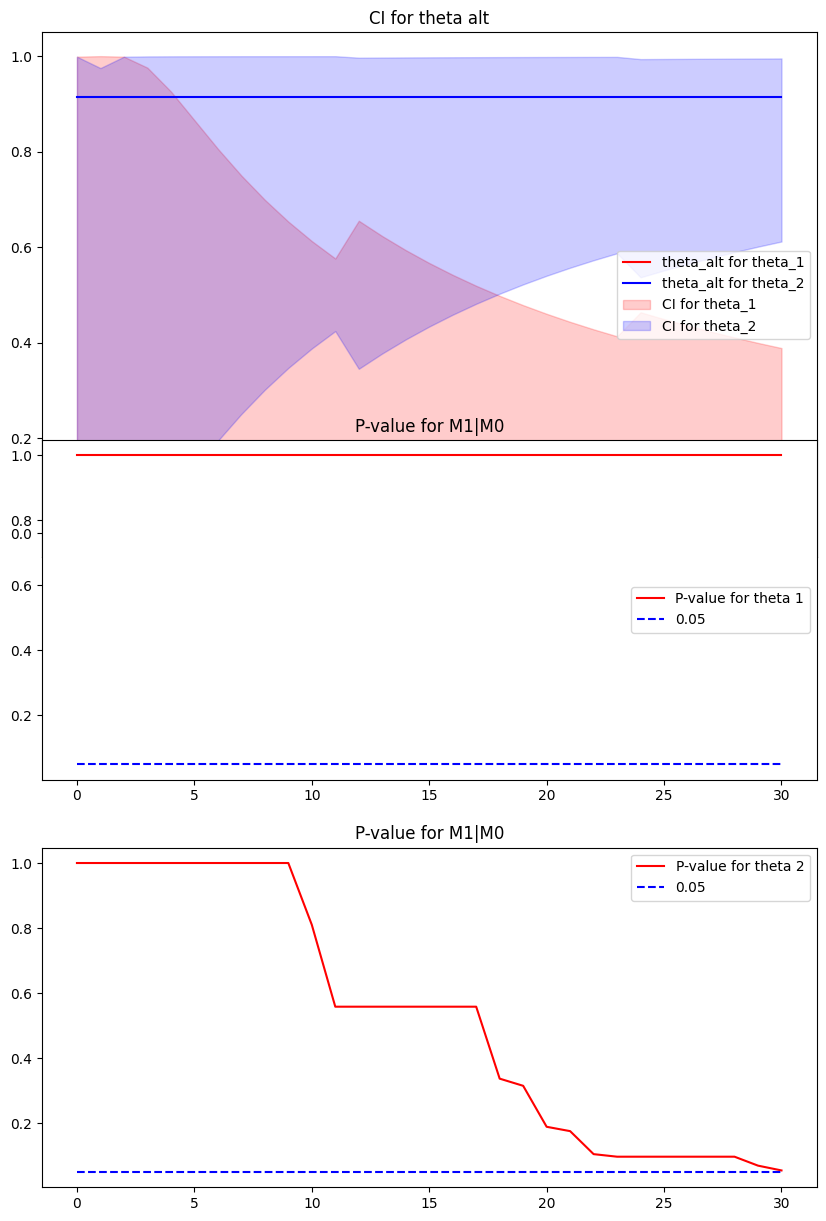

In [34]:
plt.figure(figsize=(10, 15))
plt.subplot(2,1,1)
plt.title("CI for theta alt")
lenght=len(theta_alt_0min_arr)
plt.plot(range(lenght),[theta_alt[0]]*lenght,color='r',label="theta_alt for theta_1")
plt.plot(range(lenght),[theta_alt[1]]*lenght,color='b',label="theta_alt for theta_2")

plt.fill_between(range(lenght),
                 np.array(theta_alt_0min_arr),
                 np.array(theta_alt_0max_arr), color='r',
                 alpha=0.2, label="CI for theta_1")  # alpha controls transparency


plt.fill_between(range(lenght),
                 np.array(theta_alt_1min_arr),
                 np.array(theta_alt_1max_arr), color='b',
                 alpha=0.2, label="CI for theta_2")  # alpha controls transparency


# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,0],label="theta_alt min for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,0],label="theta_alt max for theta_1")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_min_arr)[:,1],label="theta_alt min for theta_2")
# plt.plot(range(len(theta_alt_arr)),np.array(theta_alt_max_arr)[:,1],label="theta_alt max for theta_2")

plt.legend()
plt.subplot(3,1,2)
plt.title("P-value for M1|M0")
plt.plot(range(lenght),np.array(seq_p_val_arr)[:,0],color='r',label="P-value for theta 1")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()


plt.subplot(3,1,3)
plt.title("P-value for M1|M0")
plt.plot(range(lenght),np.array(seq_p_val_arr)[:,1],color='r',label="P-value for theta 2")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()

In [19]:
np.round(theta_alt_0min_arr,3)

array([0.012, 0.025, 0.012, 0.08 , 0.056, 0.121, 0.181, 0.232, 0.275,
       0.245, 0.282, 0.256, 0.288, 0.317, 0.343, 0.32 , 0.344, 0.365,
       0.384, 0.365, 0.383, 0.365, 0.348, 0.365, 0.349, 0.366, 0.381,
       0.395, 0.381, 0.394, 0.407, 0.419, 0.43 , 0.441, 0.428, 0.439,
       0.449, 0.458, 0.467, 0.476, 0.484, 0.492, 0.499, 0.507, 0.496,
       0.485, 0.492, 0.499, 0.506, 0.496, 0.503, 0.509, 0.515, 0.521,
       0.527, 0.533, 0.523, 0.529, 0.534, 0.54 , 0.545, 0.55 , 0.541,
       0.546, 0.551, 0.555, 0.56 , 0.564, 0.568, 0.573, 0.577, 0.569,
       0.561, 0.565, 0.569, 0.573, 0.566, 0.559, 0.563, 0.566, 0.559,
       0.563, 0.567, 0.56 , 0.564, 0.557, 0.561, 0.565, 0.568, 0.572,
       0.575, 0.578, 0.572, 0.575, 0.579, 0.582, 0.576, 0.579, 0.573,
       0.576])

In [20]:
np.round(theta_alt_1min_arr,3)

array([0.012, 0.   , 0.012, 0.006, 0.056, 0.04 , 0.029, 0.021, 0.016,
       0.05 , 0.041, 0.079, 0.068, 0.059, 0.052, 0.083, 0.074, 0.067,
       0.06 , 0.087, 0.08 , 0.106, 0.131, 0.123, 0.147, 0.138, 0.13 ,
       0.123, 0.144, 0.137, 0.13 , 0.123, 0.117, 0.112, 0.13 , 0.124,
       0.119, 0.114, 0.109, 0.105, 0.101, 0.097, 0.093, 0.09 , 0.104,
       0.118, 0.114, 0.111, 0.107, 0.12 , 0.117, 0.113, 0.11 , 0.107,
       0.104, 0.101, 0.113, 0.11 , 0.107, 0.104, 0.101, 0.099, 0.11 ,
       0.107, 0.104, 0.102, 0.1  , 0.097, 0.095, 0.093, 0.091, 0.101,
       0.11 , 0.108, 0.106, 0.104, 0.113, 0.121, 0.119, 0.117, 0.126,
       0.123, 0.121, 0.13 , 0.127, 0.136, 0.133, 0.131, 0.129, 0.127,
       0.125, 0.123, 0.131, 0.129, 0.127, 0.125, 0.132, 0.13 , 0.138,
       0.136])

In [21]:
np.round(theta_alt_1max_arr,3)

array([0.988, 0.975, 0.988, 0.92 , 0.944, 0.879, 0.819, 0.768, 0.725,
       0.755, 0.718, 0.744, 0.712, 0.683, 0.657, 0.68 , 0.656, 0.635,
       0.616, 0.635, 0.617, 0.635, 0.652, 0.635, 0.651, 0.634, 0.619,
       0.605, 0.619, 0.606, 0.593, 0.581, 0.57 , 0.559, 0.572, 0.561,
       0.551, 0.542, 0.533, 0.524, 0.516, 0.508, 0.501, 0.493, 0.504,
       0.515, 0.508, 0.501, 0.494, 0.504, 0.497, 0.491, 0.485, 0.479,
       0.473, 0.467, 0.477, 0.471, 0.466, 0.46 , 0.455, 0.45 , 0.459,
       0.454, 0.449, 0.445, 0.44 , 0.436, 0.432, 0.427, 0.423, 0.431,
       0.439, 0.435, 0.431, 0.427, 0.434, 0.441, 0.437, 0.434, 0.441,
       0.437, 0.433, 0.44 , 0.436, 0.443, 0.439, 0.435, 0.432, 0.428,
       0.425, 0.422, 0.428, 0.425, 0.421, 0.418, 0.424, 0.421, 0.427,
       0.424])

In [22]:
np.round(theta_alt_0max_arr,3)

array([0.988, 1.   , 0.988, 0.994, 0.944, 0.96 , 0.971, 0.979, 0.984,
       0.95 , 0.959, 0.921, 0.932, 0.941, 0.948, 0.917, 0.926, 0.933,
       0.94 , 0.913, 0.92 , 0.894, 0.869, 0.877, 0.853, 0.862, 0.87 ,
       0.877, 0.856, 0.863, 0.87 , 0.877, 0.883, 0.888, 0.87 , 0.876,
       0.881, 0.886, 0.891, 0.895, 0.899, 0.903, 0.907, 0.91 , 0.896,
       0.882, 0.886, 0.889, 0.893, 0.88 , 0.883, 0.887, 0.89 , 0.893,
       0.896, 0.899, 0.887, 0.89 , 0.893, 0.896, 0.899, 0.901, 0.89 ,
       0.893, 0.896, 0.898, 0.9  , 0.903, 0.905, 0.907, 0.909, 0.899,
       0.89 , 0.892, 0.894, 0.896, 0.887, 0.879, 0.881, 0.883, 0.874,
       0.877, 0.879, 0.87 , 0.873, 0.864, 0.867, 0.869, 0.871, 0.873,
       0.875, 0.877, 0.869, 0.871, 0.873, 0.875, 0.868, 0.87 , 0.862,
       0.864])

In [23]:
1/np.array(on_theta_hist_arr) < (1/0.05)

<ipython-input-23-be1f40693832>:1: RuntimeWarning: divide by zero encountered in divide
  1/np.array(on_theta_hist_arr) < (1/0.05)
<ipython-input-23-be1f40693832>:1: RuntimeWarning: overflow encountered in divide
  1/np.array(on_theta_hist_arr) < (1/0.05)


array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [Fal

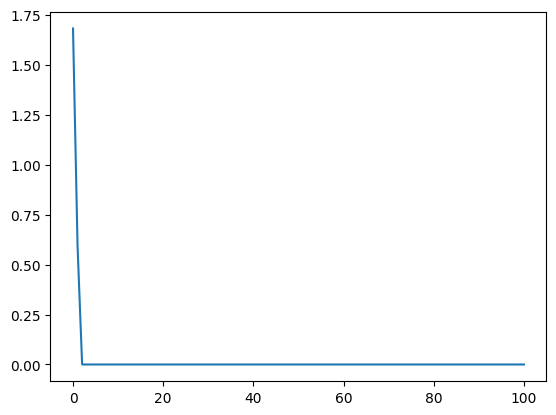

In [24]:
from scipy.stats import gaussian_kde

event_timestamps=np.array([1,2])
kde=gaussian_kde(vectors_alt[:100,1])
time_points=np.linspace(0,100,100)
plt.plot(time_points,kde(time_points))

In [25]:
time_points

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

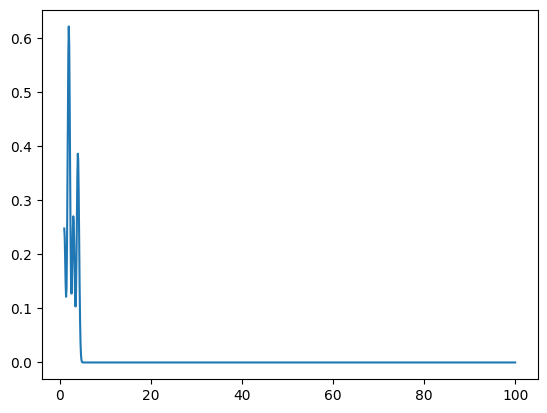

In [26]:
num_time_points=100
probabilities=np.random.dirichlet(alpha=[1,2,3,4],size=1).flatten()
num_samples=1000
event_times=np.random.choice(np.arange(1,5),size=num_samples,p=probabilities/np.sum(probabilities))
kde=gaussian_kde(event_times,bw_method='scott')
time_grid=np.linspace(1,num_time_points,1000)
mu_t=kde(time_grid)
plt.plot(time_grid,mu_t)
